In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load your dataset
# Replace 'your_dataset.csv' with the path to your dataset
data = pd.read_csv("MachineLearning.csv")

In [3]:
data['ref_date'] = pd.to_datetime(data['ref_date'])

In [6]:
data.drop('predicted_vacancies', axis=1,inplace=True)

In [7]:
data

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies
0,547960,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60480.0
1,547963,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45455.0
2,876736,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14330.0
3,876739,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10420.0
4,1534288,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",452315.0
...,...,...,...,...,...,...,...
10704,55124776,2024-04-01,Nunavut,101,"Total, all occupations","Type of work, all types",575.0
10705,55124779,2024-04-01,Nunavut,101,"Total, all occupations",Full-time,455.0
10706,55181035,2024-04-01,Nunavut,6,Sales and service occupations,"Type of work, all types",135.0
10707,55181038,2024-04-01,Nunavut,6,Sales and service occupations,Full-time,95.0


In [10]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("MachineLearning.csv")

# Convert 'ref_date' to datetime
data['ref_date'] = pd.to_datetime(data['ref_date'])

# Filter out data for 2024 (for prediction later)
train_data = data[data['ref_date'] < '2024-01-01']

# Aggregate total vacancies by geo, noc_code, and ref_date
aggregated_data = (
    train_data.groupby(['geo', 'noc_code', 'ref_date'])['total_vacancies']
    .sum()
    .reset_index()
)

# Prepare a DataFrame to store predictions
predictions = []

# Iterate through each unique combination of geo and noc_code
for (geo, noc_code), group in aggregated_data.groupby(['geo', 'noc_code']):
    # Ensure the time series is indexed by 'ref_date'
    group = group.set_index('ref_date').asfreq('QS')  # Quarterly frequency
    
    # Fill missing values in the time series
    group['total_vacancies'] = group['total_vacancies'].fillna(0)
    
    # Define SARIMAX parameters (fixed here, can be optimized)
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 4)  # Quarterly seasonality
    
    # Train SARIMAX model
    try:
        model = SARIMAX(
            group['total_vacancies'],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=0)
        
        # Forecast for 2024 (4 quarters)
        forecast = results.get_forecast(steps=4)
        forecast_df = forecast.summary_frame()
        
        # Add identifying columns to the predictions
        forecast_df['geo'] = geo
        forecast_df['noc_code'] = noc_code
        forecast_df['ref_date'] = pd.date_range(start='2024-01-01', periods=4, freq='QS')
        
        # Append the relevant columns to predictions
        predictions.append(forecast_df[['ref_date', 'geo', 'noc_code', 'mean']])
    except Exception as e:
        print(f"Error processing geo: {geo}, noc_code: {noc_code} - {e}")

# Combine predictions for all groups into a single DataFrame
predictions_df = pd.concat(predictions, ignore_index=True)

# Rename the 'mean' column to 'predicted_total_vacancies'
predictions_df.rename(columns={'mean': 'predicted_total_vacancies'}, inplace=True)





In [11]:
predictions_df

total_vacancies,ref_date,geo,noc_code,predicted_total_vacancies
0,2024-01-01,Alberta,0,70.814663
1,2024-04-01,Alberta,0,79.022485
2,2024-07-01,Alberta,0,133.546104
3,2024-10-01,Alberta,0,157.850448
4,2024-01-01,Alberta,1,17327.857740
...,...,...,...,...
563,2024-10-01,Yukon,7,295.376703
564,2024-01-01,Yukon,101,1993.743873
565,2024-04-01,Yukon,101,2639.450692
566,2024-07-01,Yukon,101,2543.640853


In [12]:
# Summarize predicted job vacancies by geography
geo_summary = predictions_df.groupby('geo')['predicted_total_vacancies'].sum().reset_index()

# Summarize predicted job vacancies by noc_code
noc_summary = predictions_df.groupby('noc_code')['predicted_total_vacancies'].sum().reset_index()

# Overall total vacancies
overall_vacancies = predictions_df['predicted_total_vacancies'].sum()

print("Geographical Summary:")
print(geo_summary)
print("\nNOC Code Summary:")
print(noc_summary)
print(f"\nOverall Predicted Vacancies for 2024: {overall_vacancies}")


Geographical Summary:
                          geo  predicted_total_vacancies
0                     Alberta               1.262155e+06
1            British Columbia               1.767259e+06
2                      Canada               1.008482e+07
3                    Manitoba               4.169795e+05
4               New Brunswick               2.206356e+05
5   Newfoundland and Labrador               1.085446e+05
6       Northwest Territories               1.373140e+04
7                 Nova Scotia               2.500397e+05
8                     Nunavut               7.858689e+03
9                     Ontario               3.292953e+06
10       Prince Edward Island               4.198969e+04
11                     Quebec               2.644225e+06
12               Saskatchewan               3.667685e+05
13                      Yukon               1.551015e+04

NOC Code Summary:
    noc_code  predicted_total_vacancies
0          0               1.603889e+04
1          1            

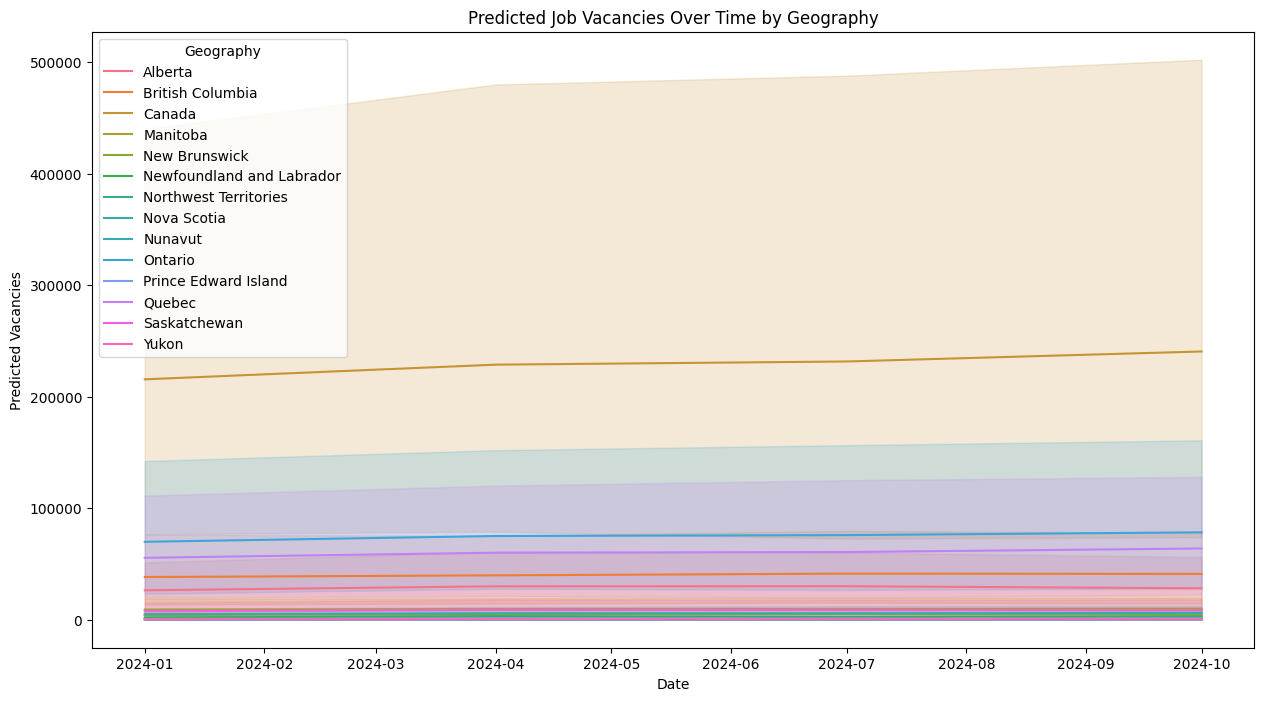

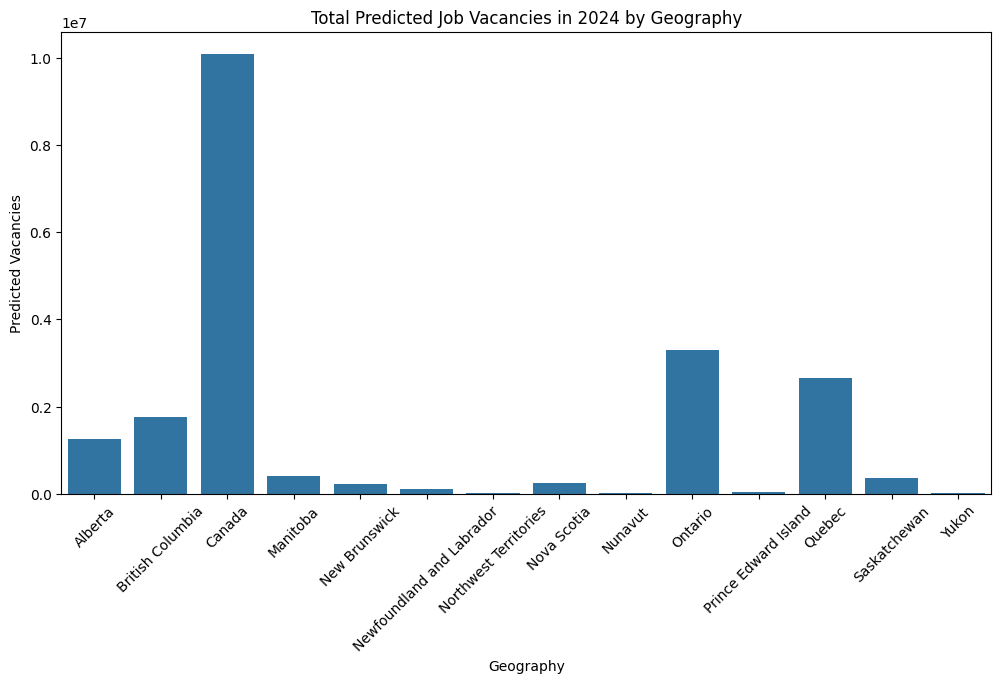

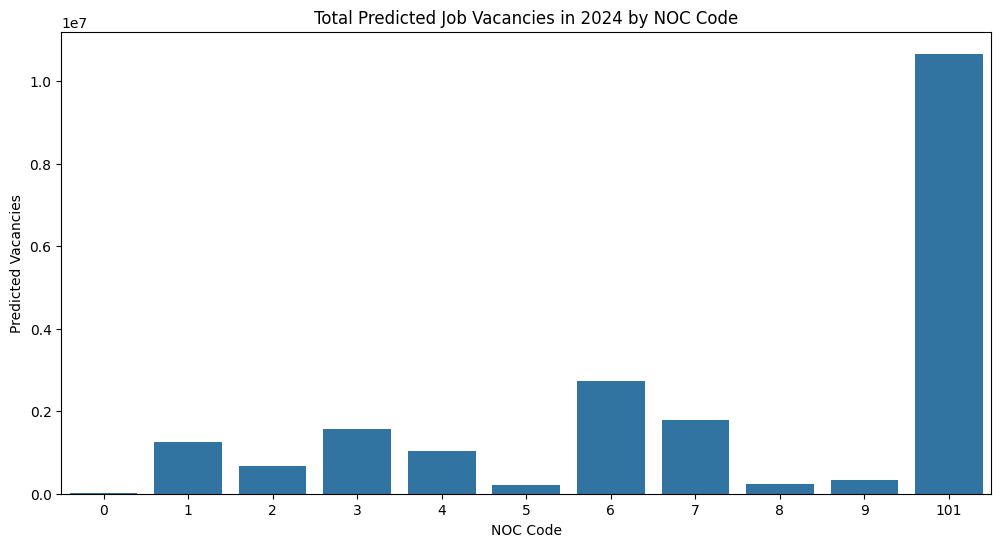

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot of predicted vacancies over time for each geography
plt.figure(figsize=(15, 8))
sns.lineplot(data=predictions_df, x='ref_date', y='predicted_total_vacancies', hue='geo')
plt.title("Predicted Job Vacancies Over Time by Geography")
plt.xlabel("Date")
plt.ylabel("Predicted Vacancies")
plt.legend(title="Geography")
plt.show()

# Bar plot of predicted vacancies by geography
plt.figure(figsize=(12, 6))
sns.barplot(data=geo_summary, x='geo', y='predicted_total_vacancies')
plt.title("Total Predicted Job Vacancies in 2024 by Geography")
plt.xlabel("Geography")
plt.ylabel("Predicted Vacancies")
plt.xticks(rotation=45)
plt.show()

# Bar plot of predicted vacancies by NOC code
plt.figure(figsize=(12, 6))
sns.barplot(data=noc_summary, x='noc_code', y='predicted_total_vacancies')
plt.title("Total Predicted Job Vacancies in 2024 by NOC Code")
plt.xlabel("NOC Code")
plt.ylabel("Predicted Vacancies")
plt.show()


In [14]:
# Aggregate historical data (2023 and earlier)
historical_summary = data[data['ref_date'] < '2024-01-01'].groupby(['geo', 'noc_code'])['total_vacancies'].sum().reset_index()

# Merge historical data with predictions
comparison_df = pd.merge(
    predictions_df.groupby(['geo', 'noc_code'])['predicted_total_vacancies'].sum().reset_index(),
    historical_summary,
    on=['geo', 'noc_code'],
    how='left'
)

# Calculate growth or decline
comparison_df['change'] = (comparison_df['predicted_total_vacancies'] - comparison_df['total_vacancies']) / comparison_df['total_vacancies'] * 100

print(comparison_df.sort_values(by='change', ascending=False))


                       geo  noc_code  predicted_total_vacancies  \
71   Northwest Territories         8               9.333333e+01   
109   Prince Edward Island         8               1.026667e+03   
90                 Nunavut         9               1.400000e+02   
89                 Nunavut         8               1.750000e+02   
86                 Nunavut         4               4.659833e+02   
..                     ...       ...                        ...   
138                  Yukon         5               3.142542e-15   
66   Northwest Territories         2              -4.563130e-04   
135                  Yukon         2              -7.025942e-04   
44           New Brunswick         0              -1.220000e+03   
67   Northwest Territories         3               0.000000e+00   

     total_vacancies       change  
71              20.0   366.666667  
109            220.0   366.666667  
90              30.0   366.666667  
89              75.0   133.333333  
86             

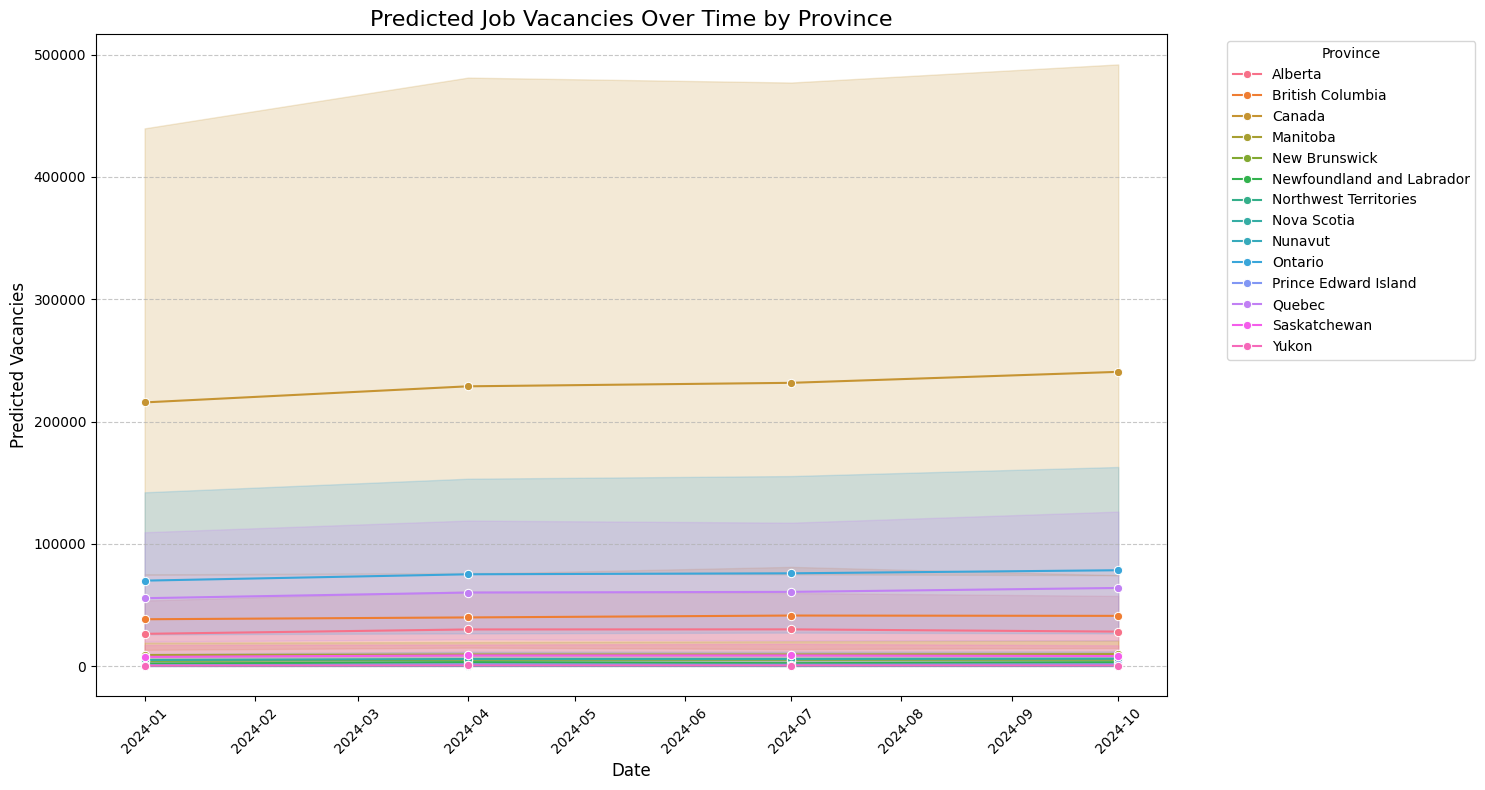

In [15]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=predictions_df, x='ref_date', y='predicted_total_vacancies', hue='geo', marker='o')
plt.title("Predicted Job Vacancies Over Time by Province", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Vacancies", fontsize=12)
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


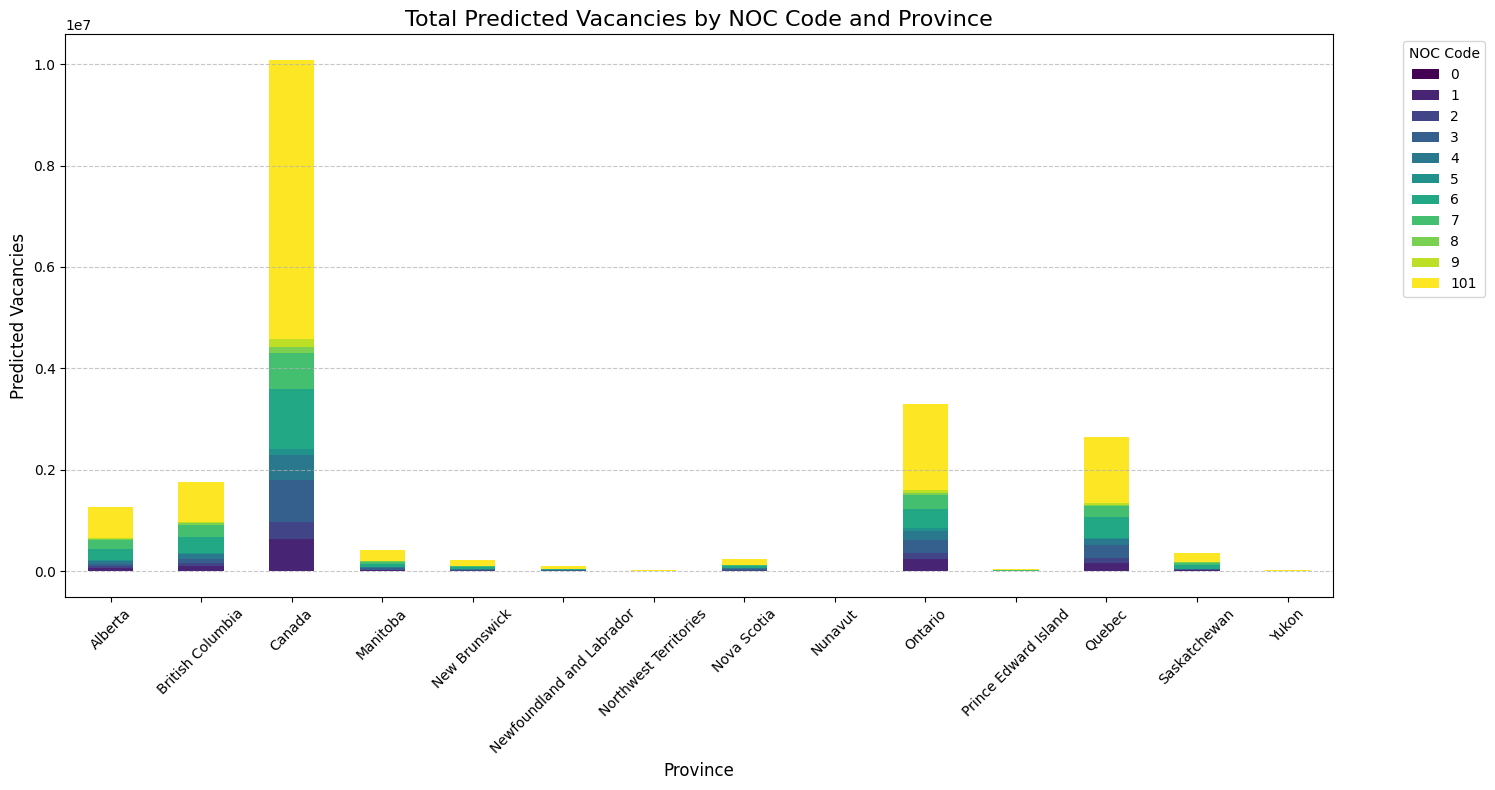

In [16]:
# Aggregate data for plotting
stacked_data = predictions_df.groupby(['geo', 'noc_code'])['predicted_total_vacancies'].sum().unstack()

# Plot
stacked_data.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')
plt.title("Total Predicted Vacancies by NOC Code and Province", fontsize=16)
plt.xlabel("Province", fontsize=12)
plt.ylabel("Predicted Vacancies", fontsize=12)
plt.legend(title="NOC Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


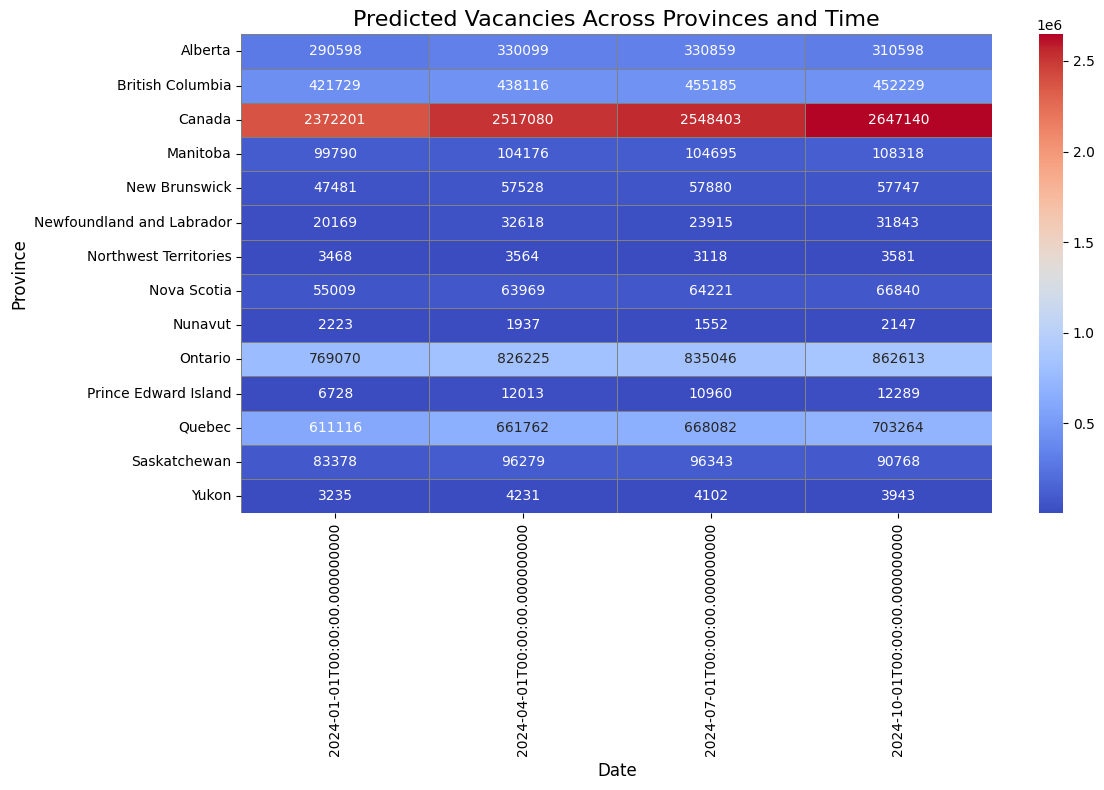

In [17]:
# Prepare data for heatmap
heatmap_data = predictions_df.pivot_table(index='geo', columns='ref_date', values='predicted_total_vacancies', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='coolwarm', linewidths=0.5, linecolor='gray')
plt.title("Predicted Vacancies Across Provinces and Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Province", fontsize=12)
plt.tight_layout()
plt.show()


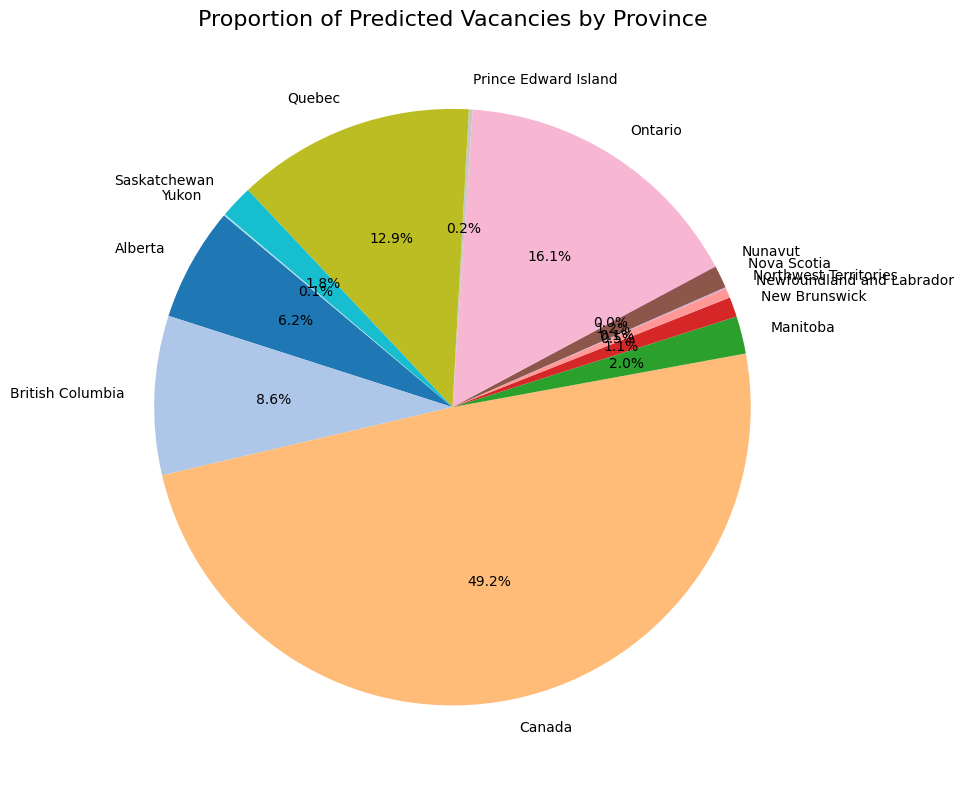

In [18]:
# Aggregate data by province
province_vacancies = predictions_df.groupby('geo')['predicted_total_vacancies'].sum()

# Plot pie chart
plt.figure(figsize=(10, 8))
province_vacancies.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title("Proportion of Predicted Vacancies by Province", fontsize=16)
plt.ylabel("")  # Hides the ylabel
plt.tight_layout()
plt.show()


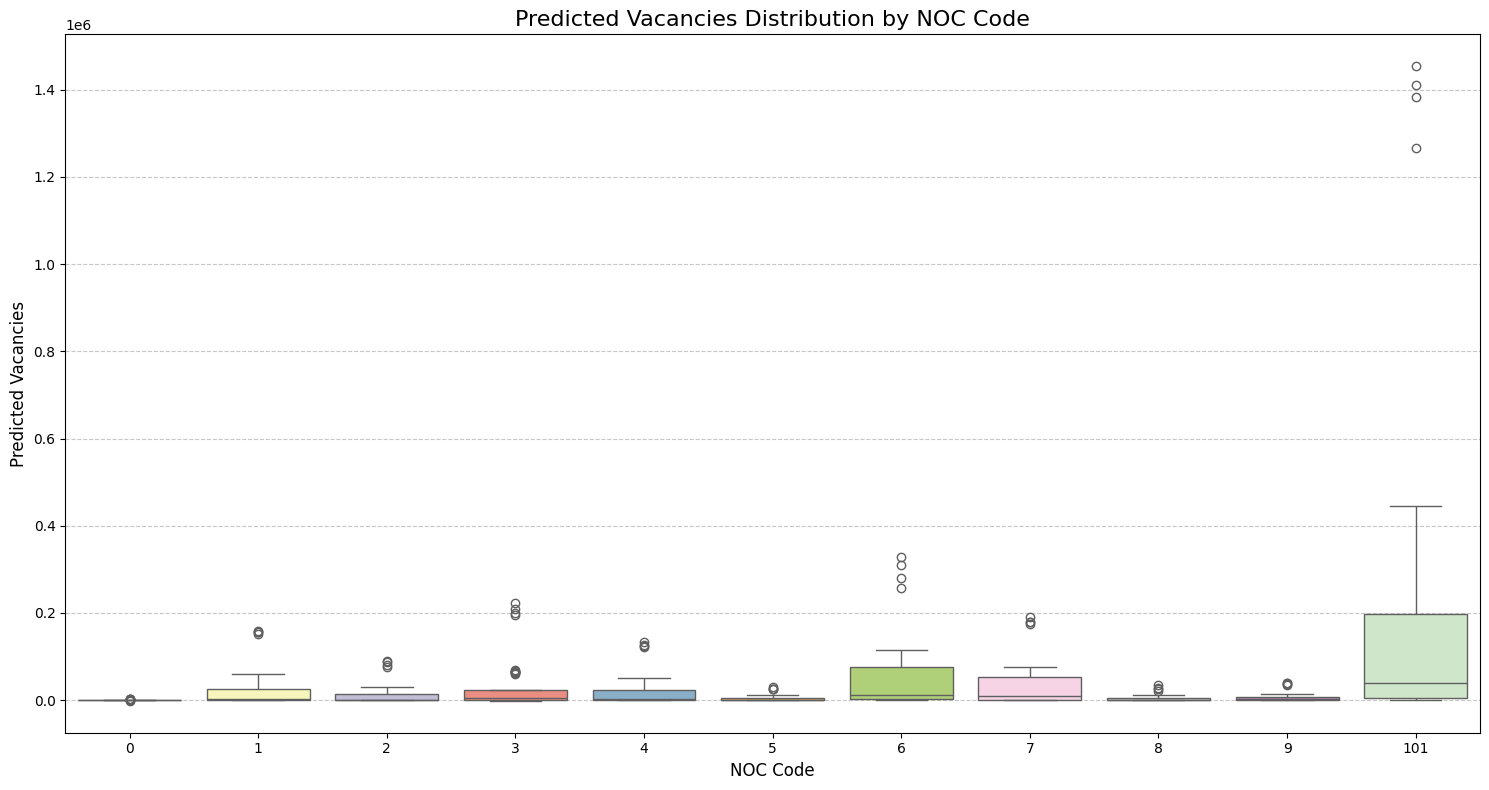

In [19]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=predictions_df, x='noc_code', y='predicted_total_vacancies', palette='Set3')
plt.title("Predicted Vacancies Distribution by NOC Code", fontsize=16)
plt.xlabel("NOC Code", fontsize=12)
plt.ylabel("Predicted Vacancies", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


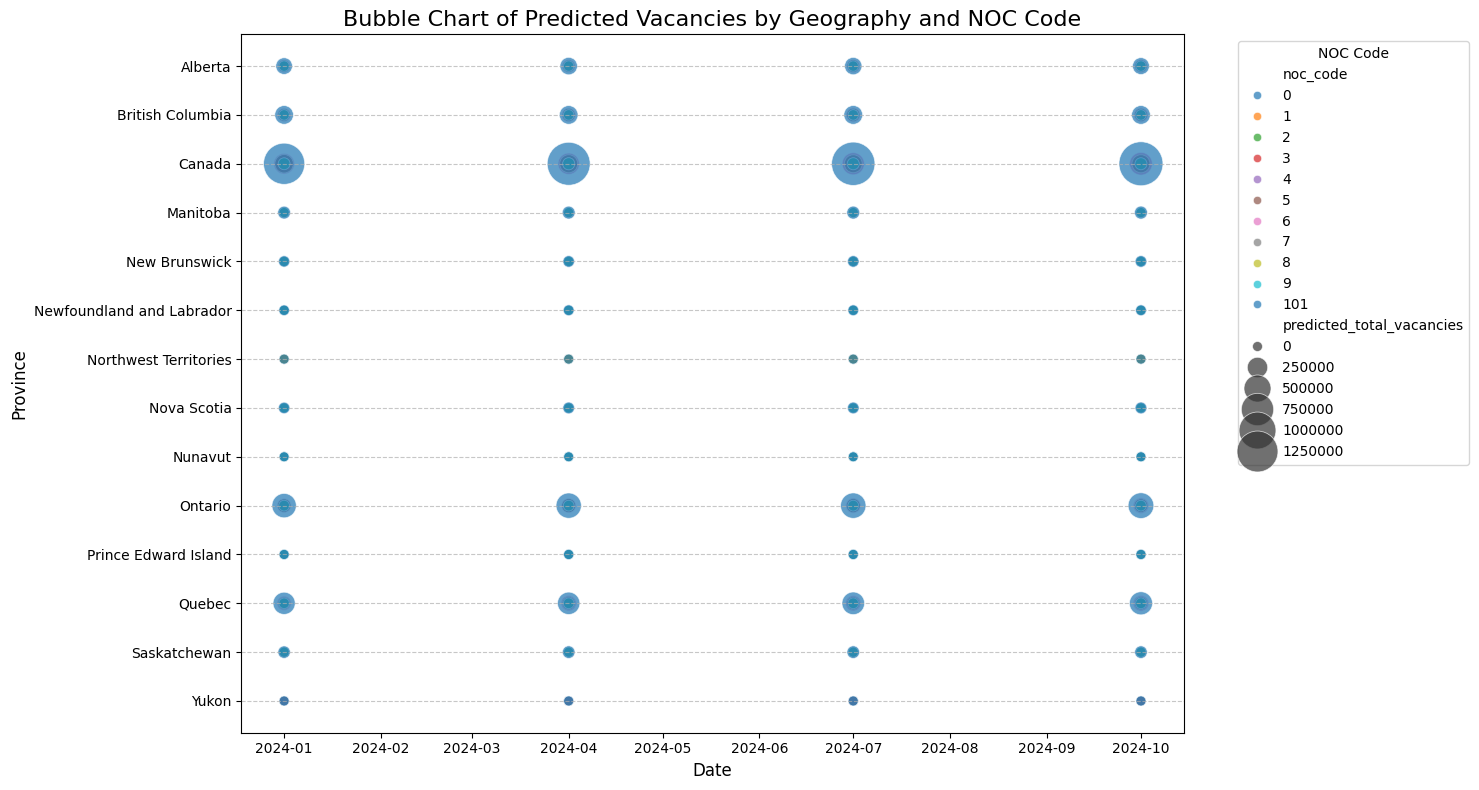

In [20]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=predictions_df, 
    x='ref_date', 
    y='geo', 
    size='predicted_total_vacancies', 
    hue='noc_code', 
    alpha=0.7, 
    palette='tab10', 
    sizes=(50, 1000)
)
plt.title("Bubble Chart of Predicted Vacancies by Geography and NOC Code", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Province", fontsize=12)
plt.legend(title="NOC Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


predictions

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Extend prediction for 2025 (or more)
future_steps = 4  # Number of future quarters
extended_predictions = []

for (geo, noc_code), group_data in train_data.groupby(['geo', 'noc_code']):
    # Re-fit SARIMAX for this group
    model = SARIMAX(
        group_data['total_vacancies'], 
        order=(1, 1, 1), 
        seasonal_order=(1, 1, 1, 4), 
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    # Forecast future steps
    forecast = result.get_forecast(steps=future_steps)
    predicted_mean = forecast.predicted_mean
    forecast_dates = pd.date_range(start='2025-01-01', periods=future_steps, freq='QS')

    # Save results
    for date, pred in zip(forecast_dates, predicted_mean):
        extended_predictions.append({
            'ref_date': date,
            'geo': geo,
            'noc_code': noc_code,
            'predicted_total_vacancies': pred
        })

# Create a DataFrame of extended predictions
extended_predictions_df = pd.DataFrame(extended_predictions)
print(extended_predictions_df.head())


    ref_date      geo  noc_code  predicted_total_vacancies
0 2025-01-01  Alberta         0                 113.707715
1 2025-04-01  Alberta         0                 112.807455
2 2025-07-01  Alberta         0                 124.059359
3 2025-10-01  Alberta         0                 121.936749
4 2025-01-01  Alberta         1                8245.471805


In [22]:
# Combine 2024 predictions with extended predictions
all_predictions = pd.concat([predictions_df, extended_predictions_df])
all_predictions.sort_values(by=['geo', 'noc_code', 'ref_date'], inplace=True)
print(all_predictions.head())


    ref_date      geo  noc_code  predicted_total_vacancies
0 2024-01-01  Alberta         0                  70.814663
1 2024-04-01  Alberta         0                  79.022485
2 2024-07-01  Alberta         0                 133.546104
3 2024-10-01  Alberta         0                 157.850448
0 2025-01-01  Alberta         0                 113.707715


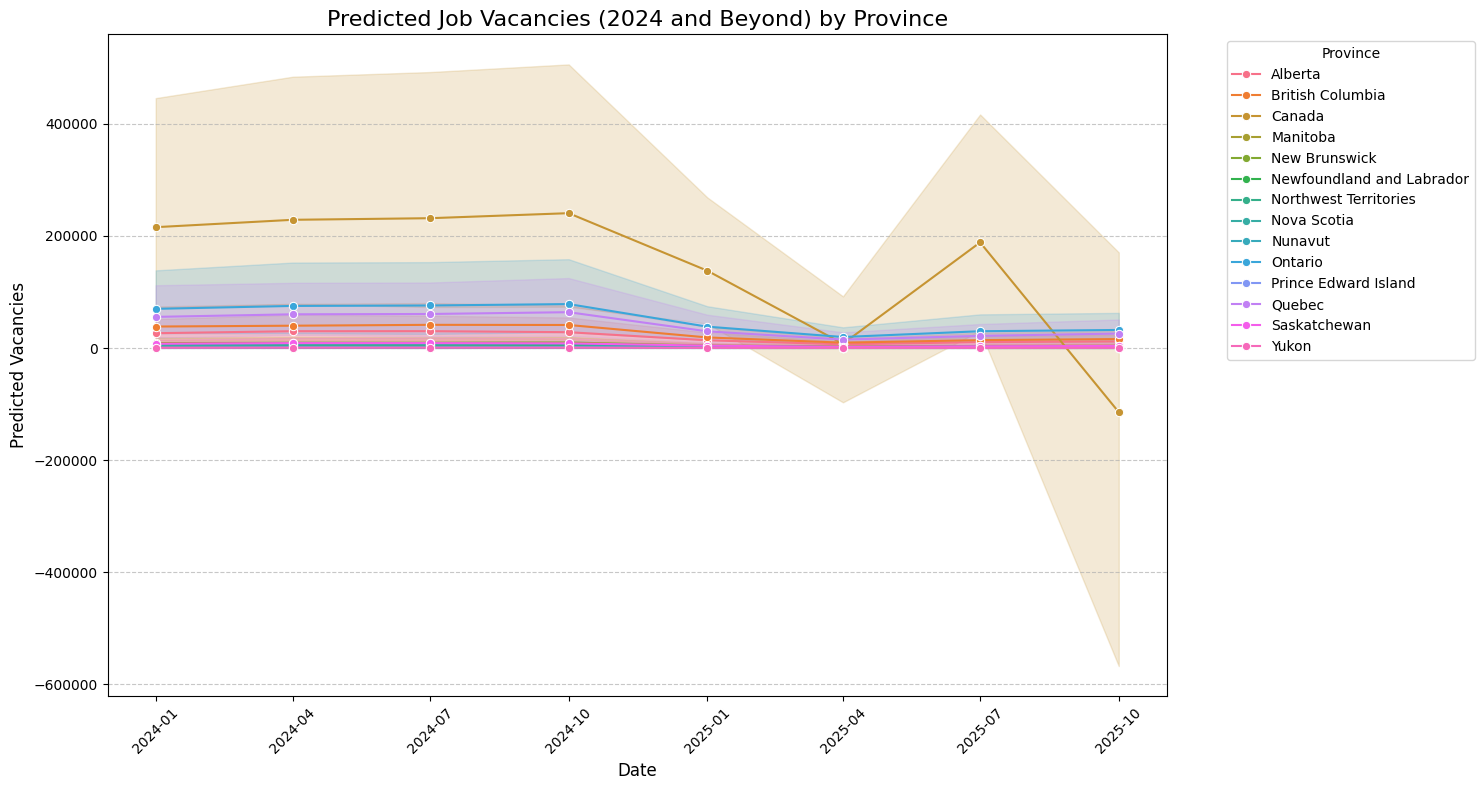

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot showing trends for 2024 and beyond
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_predictions, x='ref_date', y='predicted_total_vacancies', hue='geo', marker='o')
plt.title("Predicted Job Vacancies (2024 and Beyond) by Province", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Vacancies", fontsize=12)
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h1>predicting for 2024

In [36]:
dataset=pd.read_csv("MachineLearning.csv")

In [37]:
# Split the dataset
train_data = dataset[dataset['ref_date'] < '2024-01-01']
validation_data = dataset[(dataset['ref_date'] >= '2024-01-01') & (dataset['ref_date'] <= '2024-04-01')]

print("Training Data:", train_data['ref_date'].min(), "to", train_data['ref_date'].max())
print("Validation Data:", validation_data['ref_date'].min(), "to", validation_data['ref_date'].max())


Training Data: 2015-01-01 to 2023-10-01
Validation Data: 2024-01-01 to 2024-04-01


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMAX for each group
predictions = []
for (geo, noc_code), group_data in train_data.groupby(['geo', 'noc_code']):
    # Train the model
    model = SARIMAX(
        group_data['total_vacancies'], 
        order=(1, 1, 1), 
        seasonal_order=(1, 1, 1, 4), 
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    # Predict for 2024
    forecast = result.get_forecast(steps=4)
    predicted_mean = forecast.predicted_mean
    forecast_dates = pd.date_range(start='2024-01-01', periods=4, freq='QS')

    # Append predictions
    for date, pred in zip(forecast_dates, predicted_mean):
        predictions.append({
            'ref_date': date,
            'geo': geo,
            'noc_code': noc_code,
            'predicted_total_vacancies': pred
        })

# Create a DataFrame of predictions
predictions_df = pd.DataFrame(predictions)
print(predictions_df.head())


    ref_date      geo  noc_code  predicted_total_vacancies
0 2024-01-01  Alberta         0                 113.707715
1 2024-04-01  Alberta         0                 112.807455
2 2024-07-01  Alberta         0                 124.059359
3 2024-10-01  Alberta         0                 121.936749
4 2024-01-01  Alberta         1                8245.471805


In [39]:
# Ensure ref_date is in datetime format in both datasets
validation_data['ref_date'] = pd.to_datetime(validation_data['ref_date'])
predictions_df['ref_date'] = pd.to_datetime(predictions_df['ref_date'])

# Merge predictions with actual validation data
validation_results = validation_data.merge(
    predictions_df, 
    on=['ref_date', 'geo', 'noc_code'], 
    how='inner', 
    suffixes=('_actual', '_predicted')
)

print(validation_results.head())


       idML   ref_date     geo  noc_code  \
0  52165792 2024-01-01  Canada       101   
1  52165795 2024-01-01  Canada       101   
2  52165798 2024-01-01  Canada       101   
3  52165925 2024-01-01  Canada         0   
4  52165928 2024-01-01  Canada         0   

                                        noc_desc                 job_char  \
0                         Total, all occupations  Type of work, all types   
1                         Total, all occupations                Full-time   
2                         Total, all occupations                Part-time   
3  Legislative and senior management occupations  Type of work, all types   
4  Legislative and senior management occupations                Full-time   

   total_vacancies  predicted_vacancies  predicted_total_vacancies  
0         601755.0                  NaN              636000.769977  
1         452650.0                  NaN              636000.769977  
2         149105.0                  NaN              636000.76997

In [40]:
validation_results

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies,predicted_total_vacancies
0,52165792,2024-01-01,Canada,101,"Total, all occupations","Type of work, all types",601755.0,NaN,636000.769977
1,52165795,2024-01-01,Canada,101,"Total, all occupations",Full-time,452650.0,NaN,636000.769977
2,52165798,2024-01-01,Canada,101,"Total, all occupations",Part-time,149105.0,NaN,636000.769977
3,52165925,2024-01-01,Canada,0,Legislative and senior management occupations,"Type of work, all types",1285.0,NaN,1224.939155
4,52165928,2024-01-01,Canada,0,Legislative and senior management occupations,Full-time,1195.0,NaN,1224.939155
...,...,...,...,...,...,...,...,...,...
615,55124776,2024-04-01,Nunavut,101,"Total, all occupations","Type of work, all types",575.0,NaN,465.784096
616,55124779,2024-04-01,Nunavut,101,"Total, all occupations",Full-time,455.0,NaN,465.784096
617,55181035,2024-04-01,Nunavut,6,Sales and service occupations,"Type of work, all types",135.0,NaN,125.268213
618,55181038,2024-04-01,Nunavut,6,Sales and service occupations,Full-time,95.0,NaN,125.268213


In [41]:
# Merge predictions with actual validation data
validation_results = validation_data.merge(
    predictions_df, 
    on=['ref_date', 'geo', 'noc_code'], 
    how='inner', 
    suffixes=('_actual', '_predicted')
)

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(validation_results['total_vacancies'], validation_results['predicted_total_vacancies'])
rmse = mean_squared_error(validation_results['total_vacancies'], validation_results['predicted_total_vacancies'], squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 12146.796594084828
Root Mean Squared Error (RMSE): 52508.689524625


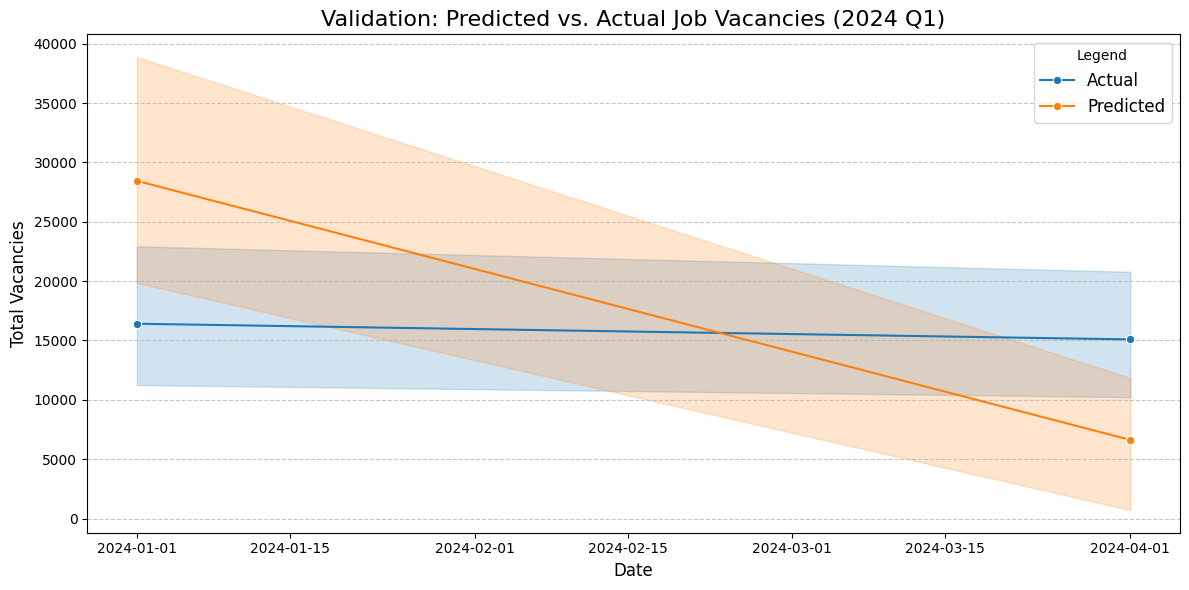

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=validation_results, x='ref_date', y='total_vacancies', label='Actual', marker='o')
sns.lineplot(data=validation_results, x='ref_date', y='predicted_total_vacancies', label='Predicted', marker='o')
plt.title("Validation: Predicted vs. Actual Job Vacancies (2024 Q1)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Vacancies", fontsize=12)
plt.legend(title="Legend", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [43]:
train_data

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,547960,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60480.0,NaN
1,547963,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45455.0,NaN
2,876736,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14330.0,NaN
3,876739,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10420.0,NaN
4,1534288,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",452315.0,NaN
...,...,...,...,...,...,...,...,...
10082,52070304,2023-10-01,Nunavut,2,Natural and applied sciences and related occup...,Part-time,0.0,NaN
10083,52112459,2023-10-01,Nunavut,6,Sales and service occupations,"Type of work, all types",155.0,NaN
10084,52112462,2023-10-01,Nunavut,6,Sales and service occupations,Full-time,115.0,NaN
10085,52126424,2023-10-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",110.0,NaN


In [44]:
from sklearn.metrics import r2_score

# Calculate Mean Absolute Percentage Error (MAPE)
validation_results['mape'] = (abs(validation_results['total_vacancies'] - validation_results['predicted_total_vacancies']) / validation_results['total_vacancies']) * 100
mape = validation_results['mape'].mean()

# Calculate R-squared (R²)
r2 = r2_score(validation_results['total_vacancies'], validation_results['predicted_total_vacancies'])

# Output the metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): -0.0780
